In [1]:
import os

# Create the Kaggle API config directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Copy kaggle.json to the config directory (notice cp not mv, and quotes)
os.system('cp "/kaggle/input/kaggleapi/kaggle (1).json" /root/.kaggle/kaggle.json')

# Change file permissions
os.system("chmod 600 /root/.kaggle/kaggle.json")

print("Kaggle API configured successfully!")

Kaggle API configured successfully!


In [2]:
import zipfile
import subprocess


datasets = {
    "pediatric_pneumonia_xray": "andrewmvd/pediatric-pneumonia-chest-xray",
    "covid_pneumonia":"prashant268/chest-xray-covid19-pneumonia",
    "adult_pneumonia":"paultimothymooney/chest-xray-pneumonia",
}

base_path = "/kaggle/working/datasets"
os.makedirs(base_path, exist_ok=True)  # Ensure the directory exists

# Download and Extract
for name, kaggle_path in datasets.items():
    dataset_path = os.path.join(base_path, name)

    if os.path.exists(dataset_path) and os.listdir(dataset_path):
        print(f"Skipping {name} - already extracted.")
        continue  # If the dataset exists, skip to the next dataset

    print(f"Downloading {name}...")
    download_command = f"kaggle datasets download -d {kaggle_path} -p {base_path}"
    
    process = subprocess.run(download_command, shell=True, capture_output=True, text=True)
    
    if process.returncode != 0:
        print(f"Error downloading {name}: {process.stderr}")
        continue  # Skip to next dataset

    zip_path = os.path.join(base_path, f"{kaggle_path.split('/')[-1]}.zip")

    if os.path.exists(zip_path):  # Ensure the zip file exists before extracting
        print(f"Extracting {name}...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(dataset_path)

        os.remove(zip_path)  # Clean up the zip file after extraction
    else:
        print(f"Failed to download {name}. Check the dataset name or Kaggle credentials.")

print("All datasets checked and processed.")

Extracting pediatric_pneumonia_xray...
Extracting covid_pneumonia...
Extracting adult_pneumonia...
All datasets checked and processed.


# Collect the Normal and Pneumonia folders in these datasets.

In [3]:
#Delete folder if previously created
dataset_path = '/kaggle/working/final_dataset'  

# Check if folder exists before deleting
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
    print(f"Folder {dataset_path} deleted successfully!")
else:
    print(f"Folder {dataset_path} does not exist.")

Folder /kaggle/working/final_dataset does not exist.


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# List of dataset paths where NORMAL and PNEUMONIA folders exist
all_datasets = [
    '/kaggle/working/datasets/adult_pneumonia/chest_xray/chest_xray',
    '/kaggle/working/datasets/covid_pneumonia/Data',
    '/kaggle/working/datasets/pediatric_pneumonia_xray/Pediatric Chest X-ray Pneumonia',
]

# New destination base path
final_dataset = '/kaggle/working/final_dataset'

# Create train, val, test structure
for split in ['train', 'val', 'test']:
    for label in ['normal', 'pneumonia']:
        os.makedirs(os.path.join(final_dataset, split, label), exist_ok=True)

# Helper to move images
def move_images(source_folder, label_name, dataset_counts):
    images = os.listdir(source_folder)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    splits = {'train': train_imgs, 'val': val_imgs, 'test': test_imgs}

    for split_name, img_list in splits.items():
        for img_name in img_list:
            src = os.path.join(source_folder, img_name)
            dst = os.path.join(final_dataset, split_name, label_name, f"{label_name}_{img_name}")
            if os.path.isfile(src):
                shutil.copy(src, dst)
                dataset_counts[label_name] += 1

# Going through each dataset
for dataset_path in all_datasets:
    dataset_name = os.path.basename(dataset_path)
    print(f"\nProcessing dataset: {dataset_name}")

    # Local counter for just this dataset
    dataset_counts = {'normal': 0, 'pneumonia': 0}

    for split_folder in ['train', 'test', 'val']:
        split_path = os.path.join(dataset_path, split_folder)
        if not os.path.exists(split_path):
            continue  # skip if no train/test/val folder

        for label in ['NORMAL', 'PNEUMONIA']:
            label_path = os.path.join(split_path, label)
            if not os.path.exists(label_path):
                continue  # skip if no NORMAL/PNEUMONIA folder

            if label == 'NORMAL':
                move_images(label_path, label_name='normal', dataset_counts=dataset_counts)
            elif label == 'PNEUMONIA':
                move_images(label_path, label_name='pneumonia', dataset_counts=dataset_counts)

    # After finishing one dataset, print how many added
    print(f"Added from {dataset_name}: Normal = {dataset_counts['normal']} | Pneumonia = {dataset_counts['pneumonia']}")

print("\nAll datasets processed!")


Processing dataset: chest_xray
Added from chest_xray: Normal = 1585 | Pneumonia = 4275

Processing dataset: Data
Added from Data: Normal = 1583 | Pneumonia = 4273

Processing dataset: Pediatric Chest X-ray Pneumonia
Added from Pediatric Chest X-ray Pneumonia: Normal = 1583 | Pneumonia = 4273

All datasets processed!


In [5]:
print("Final counts:")

for split in ['train', 'val', 'test']:
    normal_count = len(os.listdir(os.path.join(final_dataset, split, 'normal')))
    pneumonia_count = len(os.listdir(os.path.join(final_dataset, split, 'pneumonia')))
    print(f"{split.upper()}: Normal = {normal_count} | Pneumonia = {pneumonia_count}")

Final counts:
TRAIN: Normal = 2728 | Pneumonia = 7436
VAL: Normal = 429 | Pneumonia = 1205
TEST: Normal = 439 | Pneumonia = 1201


# Visualize 3 random images from both folders

2728
7436


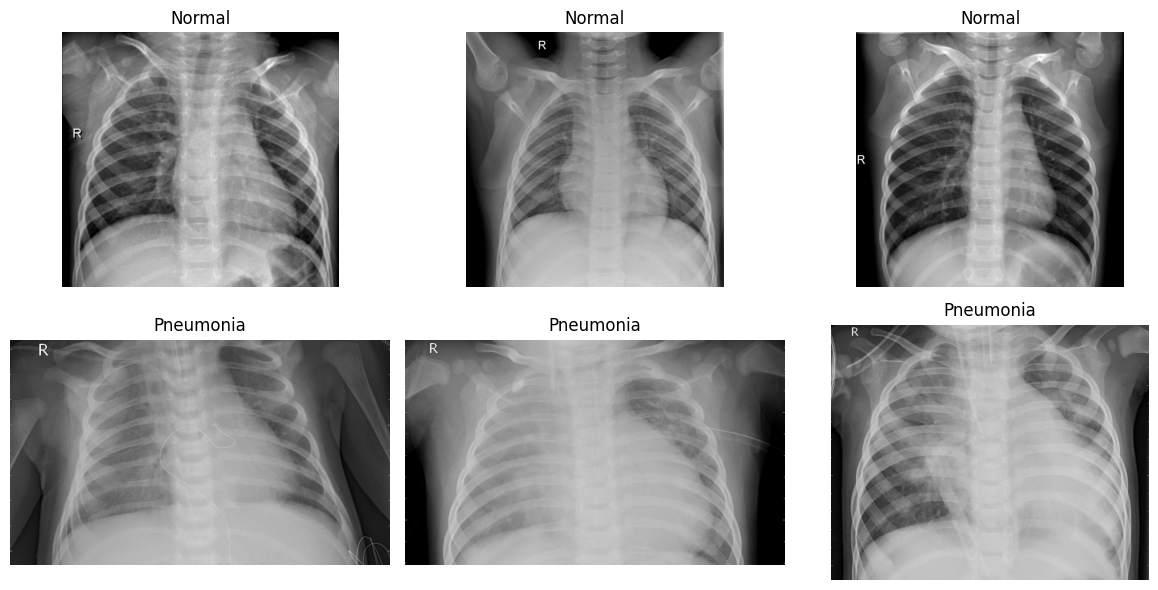

In [6]:
import random
import matplotlib.pyplot as plt
from PIL import Image


normal_folder = '/kaggle/working/final_dataset/train/normal'
pneumonia_folder = '/kaggle/working/final_dataset/train/pneumonia'


normal_images = random.sample(os.listdir(normal_folder), 3)
pneumonia_images = random.sample(os.listdir(pneumonia_folder), 3)

print(len(os.listdir(normal_folder)))
print(len(os.listdir(pneumonia_folder)))


plt.figure(figsize=(12, 6))

# First row: NORMAL
for i, img_name in enumerate(normal_images):
    img_path = os.path.join(normal_folder, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')
    plt.axis('off')

# Second row: PNEUMONIA
for i, img_name in enumerate(pneumonia_images):
    img_path = os.path.join(pneumonia_folder, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 3, i+4)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [8]:
train_dir = '/kaggle/working/final_dataset/train'
val_dir = '/kaggle/working/final_dataset/val'
test_dir = '/kaggle/working/final_dataset/test'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), #resnet model expects 3-channels 
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(degrees=10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0))
    ], p=0.7),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [9]:
#Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)


In [10]:
#DataLoadets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Utilizing a pretrained model

In [11]:
#Models - Pretrained ResNet
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


In [12]:
num_epochs = 20
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss= 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss/len(train_dataset)
    epoch_acc = running_corrects.double()/ len(train_dataset)

    # Validation
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_acc = val_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {epoch_loss:.4f} | Train Acc {epoch_acc:.4f} | Val Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet18_pneumonia.pt')

print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 1/20: Train Loss 0.1184 | Train Acc 0.9562 | Val Acc 0.9767
Epoch 2/20: Train Loss 0.0635 | Train Acc 0.9762 | Val Acc 0.9847
Epoch 3/20: Train Loss 0.0518 | Train Acc 0.9822 | Val Acc 0.9902
Epoch 4/20: Train Loss 0.0372 | Train Acc 0.9868 | Val Acc 0.9902
Epoch 5/20: Train Loss 0.0310 | Train Acc 0.9894 | Val Acc 0.9823
Epoch 6/20: Train Loss 0.0269 | Train Acc 0.9901 | Val Acc 0.9890
Epoch 7/20: Train Loss 0.0232 | Train Acc 0.9917 | Val Acc 0.9963
Epoch 8/20: Train Loss 0.0237 | Train Acc 0.9923 | Val Acc 0.9890
Epoch 9/20: Train Loss 0.0179 | Train Acc 0.9939 | Val Acc 0.9823
Epoch 10/20: Train Loss 0.0131 | Train Acc 0.9953 | Val Acc 0.9945
Epoch 11/20: Train Loss 0.0162 | Train Acc 0.9948 | Val Acc 0.9853
Epoch 12/20: Train Loss 0.0159 | Train Acc 0.9942 | Val Acc 0.9951
Epoch 13/20: Train Loss 0.0156 | Train Acc 0.9945 | Val Acc 0.9969
Epoch 14/20: Train Loss 0.0105 | Train Acc 0.9967 | Val Acc 0.9835
Epoch 15/20: Train Loss 0.0142 | Train Acc 0.9956 | Val Acc 0.9933
Epoc

In [13]:
# Final Testing
model.load_state_dict(torch.load('best_resnet18_pneumonia.pt'))
model.eval()
test_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_dataset)
print(f" Final Test Accuracy: {test_acc:.4f}")

/tmp/ipykernel_19/877007767.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18_pneumonia.pt'))


 Final Test Accuracy: 0.9988
